# Обучение

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms

import sys
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython.display import clear_output

In [ ]:
train_dataset = datasets.MNIST('../data',
                               train=True,
                               download=True,
                               transform=transforms.Compose(
                                   [
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                                   ]
                                                            )
                               )
test_dataset = datasets.MNIST('.',
                              train=False,
                              download=True,
                              transform=transforms.Compose(
                                  [
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                  ]
                                  )
                              )


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

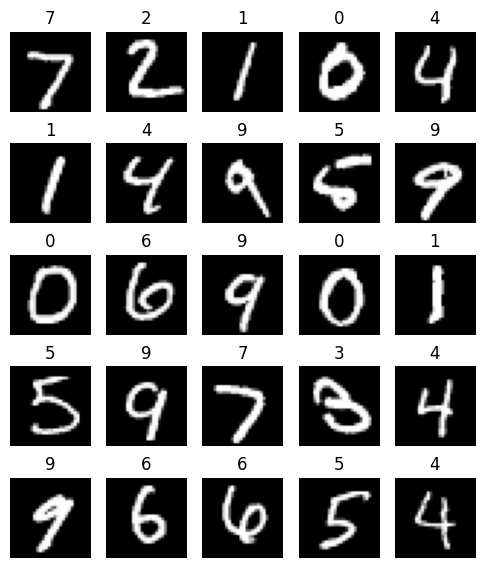

In [ ]:
X, y = next(iter(test_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [ ]:
network = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)

In [ ]:
class Network(nn.Module):
  def __init__(self, input=28*28):
    self.net = nn.Sequential(
        nn.Linear(28*28, 100),
        nn.ReLU(),
        nn.Linear(100, 100),
        nn.ReLU(),
        nn.Linear(100, 10),
        nn.LogSoftmax(dim=1)
        )
  def forward(self, x):
    return self.net(x)

In [ ]:
def train(network, criterion, epochs, optimizer, train_loader, test_loader, device):
  network.to(device)
  train_loss_epochs = []
  test_loss_epochs = []
  train_accuracy_epochs = []
  test_accuracy_epochs = []

  for epoch in tqdm(range(epochs)):
      losses_step = []
      accuracies_step = []

      network.train()
      for X, y in train_loader:
          optimizer.zero_grad()

          X = X.view(X.shape[0], -1).to(device)
          prediction = network(X)
          loss = criterion(prediction, y.to(device))

          loss.backward()
          optimizer.step()
          losses_step.append(loss.item())
          accuracies_step.append((torch.argmax(prediction.cpu(), 1) == y.cpu()).sum().item() / len(y))
      train_loss_epochs.append(np.mean(losses_step))
      train_accuracy_epochs.append(np.mean(accuracies_step))

      losses_step = []
      accuracies_step = []
      network.eval()
      for X, y in test_loader:

          X = X.view(X.shape[0], -1).to(device)
          prediction = network(X)
          loss = criterion(prediction, y.to(device))
          losses_step.append(loss.item())
          accuracies_step.append((torch.argmax(prediction.cpu(), 1) == y.cpu()).sum().item() / len(y))
      test_loss_epochs.append(np.mean(losses_step))
      test_accuracy_epochs.append(np.mean(accuracies_step))
      # plot

      clear_output(True)
      sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.plot(train_loss_epochs, label='Train')
      plt.plot(test_loss_epochs, label='Test')

      plt.xlabel('Epochs', fontsize=16)
      plt.ylabel('Loss', fontsize=16)
      plt.legend(loc=0, fontsize=16)
      plt.grid('on')
      plt.subplot(1, 2, 2)
      plt.plot(train_accuracy_epochs, label='Train accuracy')
      plt.plot(test_accuracy_epochs, label='Test accuracy')
      plt.xlabel('Epochs', fontsize=16)
      plt.ylabel('Accuracy', fontsize=16)
      plt.legend(loc=0, fontsize=16)
      plt.grid('on')
      plt.show()

Epoch 14... (Train/Test) NLL: 0.223/0.219	Accuracy: 0.937/0.938

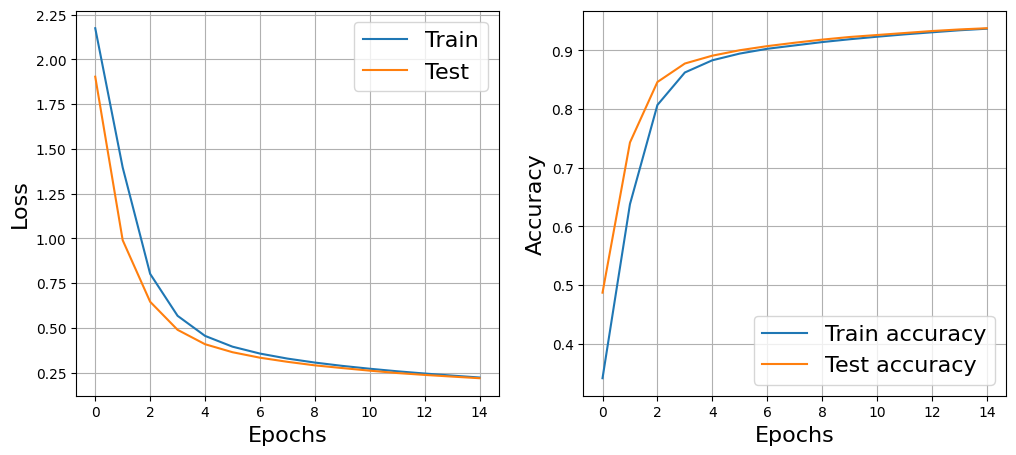

100%|██████████| 15/15 [04:59<00:00, 19.96s/it]


In [ ]:
train(network, nn.NLLLoss(), 15, torch.optim.SGD(params=network.parameters(), lr=0.01), train_loader, test_loader, device='cuda')

## pytorch lightning

In [ ]:
!pip install pytorch_lightning

In [ ]:
import pytorch_lightning as pl

In [ ]:
class Pl_model(pl.LightningModule):
    def __init__(self, network, criterion, lr):
        super().__init__()
        self.criterion = criterion
        self.network = network
        self.lr = lr

    def forward(self, x):
      X.view(X.shape[0], -1)
      prediction = network(X)
      return prediction

    def training_step(self, batch, batch_idx):
       X, y  = batch
       X = X.view(X.shape[0], -1)
       prediction = network(X)
       loss = self.criterion(prediction, y)

       accuracy = (torch.argmax(prediction.cpu(), 1) == y.cpu()).sum().item() / len(y)
       self.log_dict(
            {
                "train_loss": loss,
                "train_accuracy": accuracy,
            },
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
        )

       return loss

    def validation_step(self, batch, batch_idx):
       X, y  = batch
       X = X.view(X.shape[0], -1)
       prediction = network(X)
       loss = self.criterion(prediction, y)
       accuracy = (torch.argmax(prediction.cpu(), 1) == y.cpu()).sum().item() / len(y)
       self.log_dict(
            {
                "valid_loss": loss,
                "valid_accuracy": accuracy,
            },
            on_epoch=True,
            prog_bar=True,
            sync_dist=True,
        )

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor

checkpoint_callback = ModelCheckpoint(
        monitor="valid_loss",
        mode='min',
        save_top_k=1,
    )

network = nn.Sequential(
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.LogSoftmax(dim=1)
)

pl_model = Pl_model(network, nn.NLLLoss(), 0.01)


trainer = pl.Trainer(
    accelerator="gpu",
    devices="auto",
    max_epochs=15,
    callbacks=[checkpoint_callback]
    )

trainer.fit(pl_model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | criterion | NLLLoss    | 0      | train
1 | network   | Sequential | 89.6 K | train
-------------------------------------------------
89.6 K    Trainable params
0         Non-trainable params
89.6 K    Total params
0.358     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.
